generating object points and image points

[[ 0.  0.  0.]
 [ 1.  0.  0.]
 [ 2.  0.  0.]
 ...
 [21. 16.  0.]
 [22. 16.  0.]
 [23. 16.  0.]]


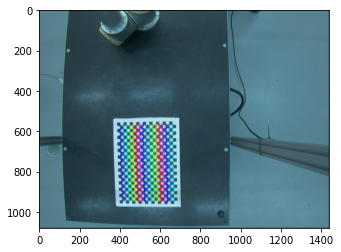

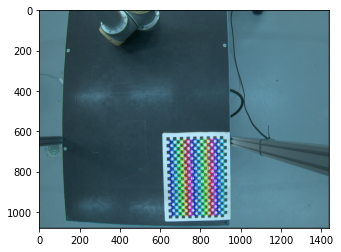

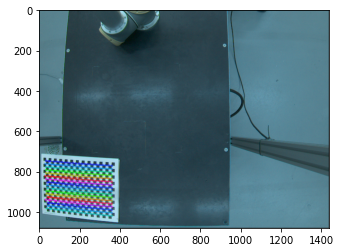

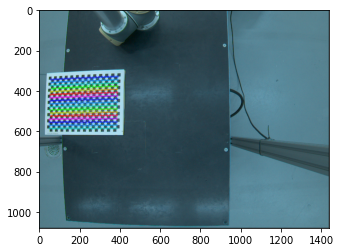

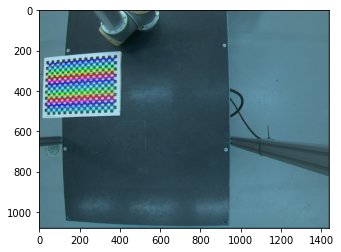

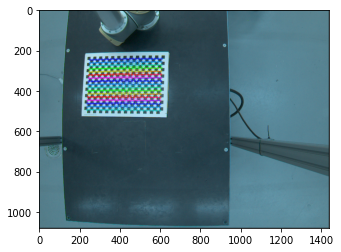

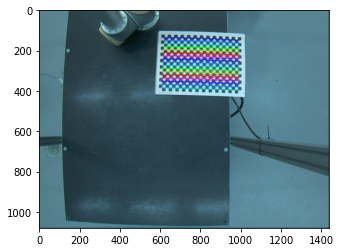

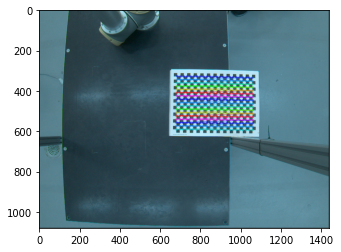

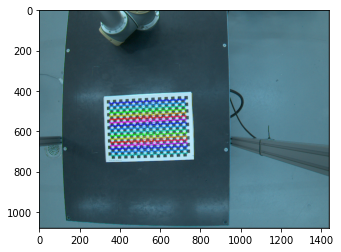

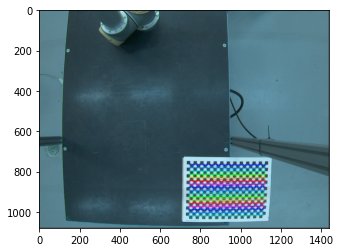

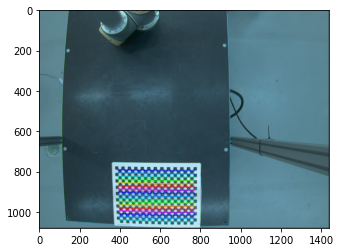

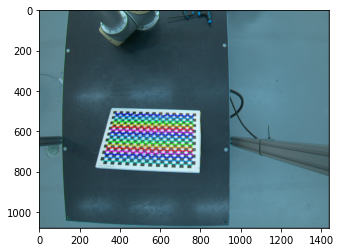

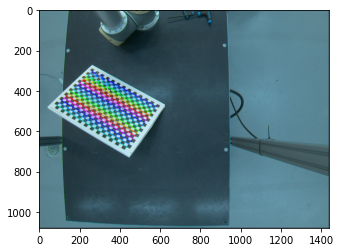

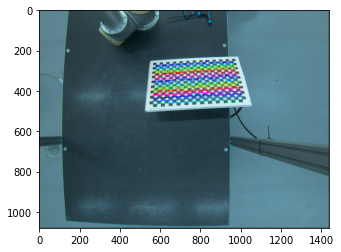

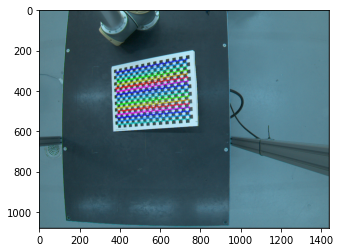

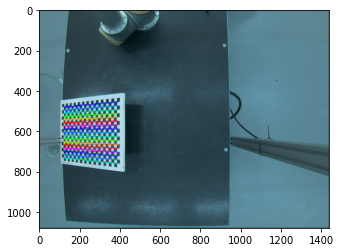

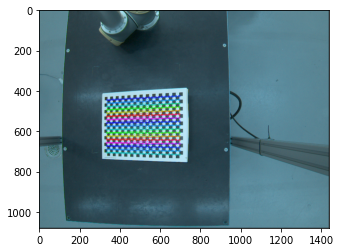

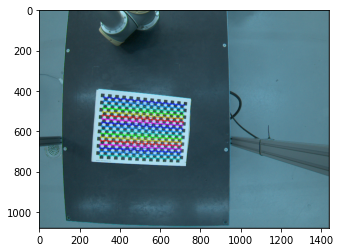

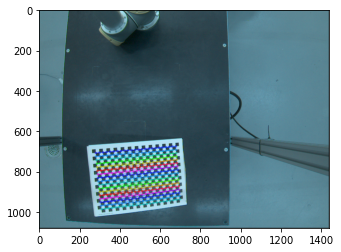

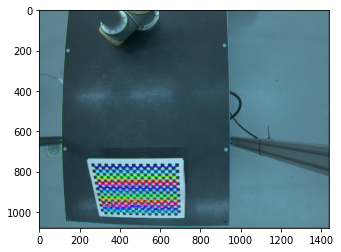

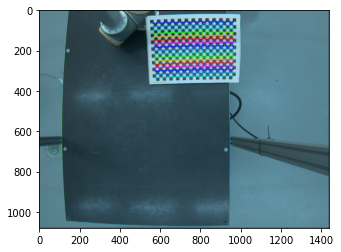

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob

chessboardSize = (24,17)
frameSize = (1440,1080)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((chessboardSize[0]*chessboardSize[1],3), np.float32)
objp[:,:2] = np.mgrid[0:chessboardSize[0],0:chessboardSize[1]].T.reshape(-1,2)

print(objp)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('images/*.png')
for fname in images:
    
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, chessboardSize, None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, chessboardSize, corners2, ret)
        plt.imshow(img,cmap='gray')
        plt.show()
         


callibrating camera

In [3]:
ret, cameraMatrix, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,frameSize,None,None)

print("camera calibrated: ",ret)
print("\nCamera matrix\n", cameraMatrix)
print("\nDistortion Parameters\n", dist)
print("\nrotational vectors\n", rvecs)
print("\ntranslation vectors\n", tvecs)

camera calibrated:  1.8562855738028041

Camera matrix
 [[1.17232635e+03 0.00000000e+00 7.42502162e+02]
 [0.00000000e+00 1.17209523e+03 5.90997158e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion Parameters
 [[-0.24740003  0.14635807  0.00079243 -0.00039257 -0.081573  ]]

rotational vectors
 (array([[-1.39446966e-02],
       [ 1.27438283e-03],
       [-1.58772930e+00]]), array([[-0.01642824],
       [-0.00286532],
       [-1.59347947]]), array([[-0.01361592],
       [-0.00132749],
       [ 0.03738717]]), array([[-0.00782643],
       [-0.00045227],
       [ 0.00117428]]), array([[-0.00472004],
       [-0.00206095],
       [-0.01960003]]), array([[-0.01055473],
       [ 0.00135928],
       [ 0.02070906]]), array([[-0.00772694],
       [ 0.00778677],
       [ 0.02864928]]), array([[-0.01017639],
       [ 0.00752831],
       [ 0.00998126]]), array([[-0.01571768],
       [ 0.00012737],
       [-0.04090067]]), array([[-0.00755782],
       [ 0.0006851 ],
       [ 0.01628382]])

Undistoring image

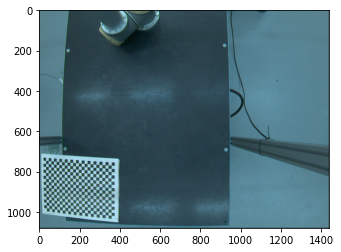

In [4]:
img = cv2.imread('images\Image__2018-10-05__10-30-08.png')
plt.imshow(img)
plt.show()

we can refine the camera matrix based on a free scaling parameter using cv.getOptimalNewCameraMatrix(). If the scaling parameter alpha=0, it returns undistorted image with minimum unwanted pixels. So it may even remove some pixels at image corners. If alpha=1, all pixels are retained with some extra black images. This function also returns an image ROI which can be used to crop the result.

In [5]:
h, w = img.shape[:2]
newCameraMatrix, roi = cv2.getOptimalNewCameraMatrix(cameraMatrix,dist,(w,h),1,(w,h))

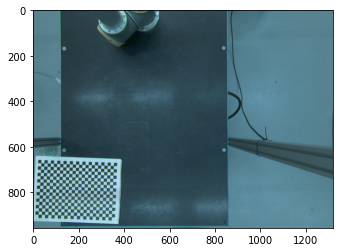

In [6]:
dst = cv2.undistort(img,cameraMatrix,dist,None,newCameraMatrix)
x,y,w,h = roi
dst = dst[y:y+h,x:x+w]
plt.imshow(dst)
plt.show()

undistort using remapping 

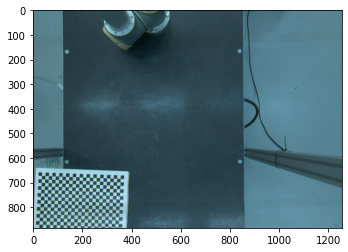

In [7]:
mapx,mapy = cv2.initUndistortRectifyMap(cameraMatrix,dist,None,newCameraMatrix,(w,h),5)
dst = cv2.remap(img,mapx,mapy,cv2.INTER_LINEAR)
x,y,w,h = roi
dst = dst[y:y+h,x:x+w]
plt.imshow(dst)
plt.show()
# cv2.imwrite('undistorted-1.png',dst)


In [8]:
mean_error = 0
for i in range (len(objpoints)):
    imgpoints2,_ = cv2.projectPoints(objpoints[i],rvecs[i],tvecs[i],cameraMatrix,dist)
    error = cv2.norm(imgpoints[i],imgpoints2,cv2.NORM_L2)/len(imgpoints2)
    mean_error += error

print("\ntotal error: {}".format(mean_error/len(objpoints)))    


total error: 0.056845000270367436
